# Google Drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from src.detector import crop_coin, create_circular_mask
import pandas as pd
from src.utils import *
from PIL import Image
import os
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import clear_output
import seaborn as sns

In [4]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Image                    module      <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
KEYWORD                  str         Sztandar 1930
MARCINIAK                str         marciniak
MARCINIAK_DATASET_PATH   str         ../data/marciniak/sztandar_1930
NGC_grading              dict        n=16
NIEMCZYK                 str         niemczyk
NIEMCZYK_DATASET_PATH    str         ../data/niemczyk/sztandar_1930
ROOT_PATH                str         ..
adj_grade_pattern        str         [12345L][+-]?(/[12345L][+-]?)?
aligned_coins_path       function    <function <lambda> at 0x121889550>
basic_grading            dict        n=16
clear_output             function    <function clear_output at 0x1017bbaf0>
companies                list        n=3
company_grade_pattern    str         (GCN|NGC|PCGS) (UNC|PF|MS|AU|XF|VF)\s?(\d{2})?
crop_coin                function    <function crop_coin at 0x12188

# Data exploration

In [5]:
def calculate_sizes(root, csv_path):
    names = [name for name in os.listdir(root) if name.split(".")[-1] == "jpg"]
    df = pd.DataFrame({"name": names, "size": None})

    pbar = tqdm(total=len(df))
    for i, row in df.iterrows():
      row["size"] = Image.open(root + "/" + row["name"]).size[0]
      pbar.update(1)
    df.to_csv(csv_path, index=None)
    pbar.close()

calculate_sizes(aligned_coins_path(NIEMCZYK_DATASET_PATH), size_aligned_path(NIEMCZYK_DATASET_PATH))
calculate_sizes(aligned_coins_path(MARCINIAK_DATASET_PATH), size_aligned_path(MARCINIAK_DATASET_PATH))

  0%|          | 0/916 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

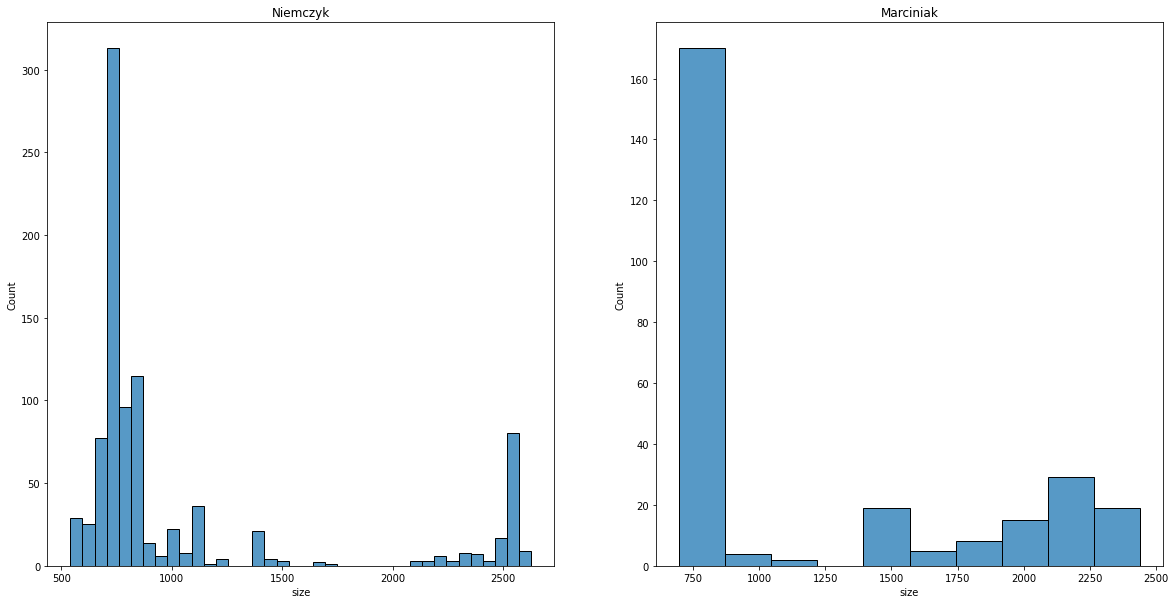

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i, ds_path in enumerate([NIEMCZYK_DATASET_PATH, MARCINIAK_DATASET_PATH]):
  df = pd.read_csv(size_aligned_path(ds_path))
  sns.histplot(df["size"], ax=ax[i])

ax[0].set_title("Niemczyk")
ax[1].set_title("Marciniak")
plt.show()


# Master coin

In [12]:
def generate_master_coin(root, label):
  df1 = pd.read_csv(size_aligned_path(root))
  df2 = pd.read_csv(side_path(root))
  df = df1.merge(df2, how='inner', on='name')
  df = df.sort_values(by=['size'], ascending=False)
  df = df[df["label"] == label]
  names = df["name"]
  stack = np.stack([cv2.resize(cv2.imread(aligned_coins_path(root) + "/" + name), (700,700)) for name in names[:100]])
  master_coin = np.uint8(np.mean(stack, axis=0))

  return master_coin

master_coin_1_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/1.jpg", master_coin_1_n)
master_coin_2_n = generate_master_coin(NIEMCZYK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(NIEMCZYK_DATASET_PATH) + "/2.jpg", master_coin_2_n)
master_coin_1_m = generate_master_coin(MARCINIAK_DATASET_PATH, 1)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg", master_coin_1_m)
master_coin_2_m = generate_master_coin(MARCINIAK_DATASET_PATH, 2)
cv2.imwrite(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg", master_coin_2_m)

True

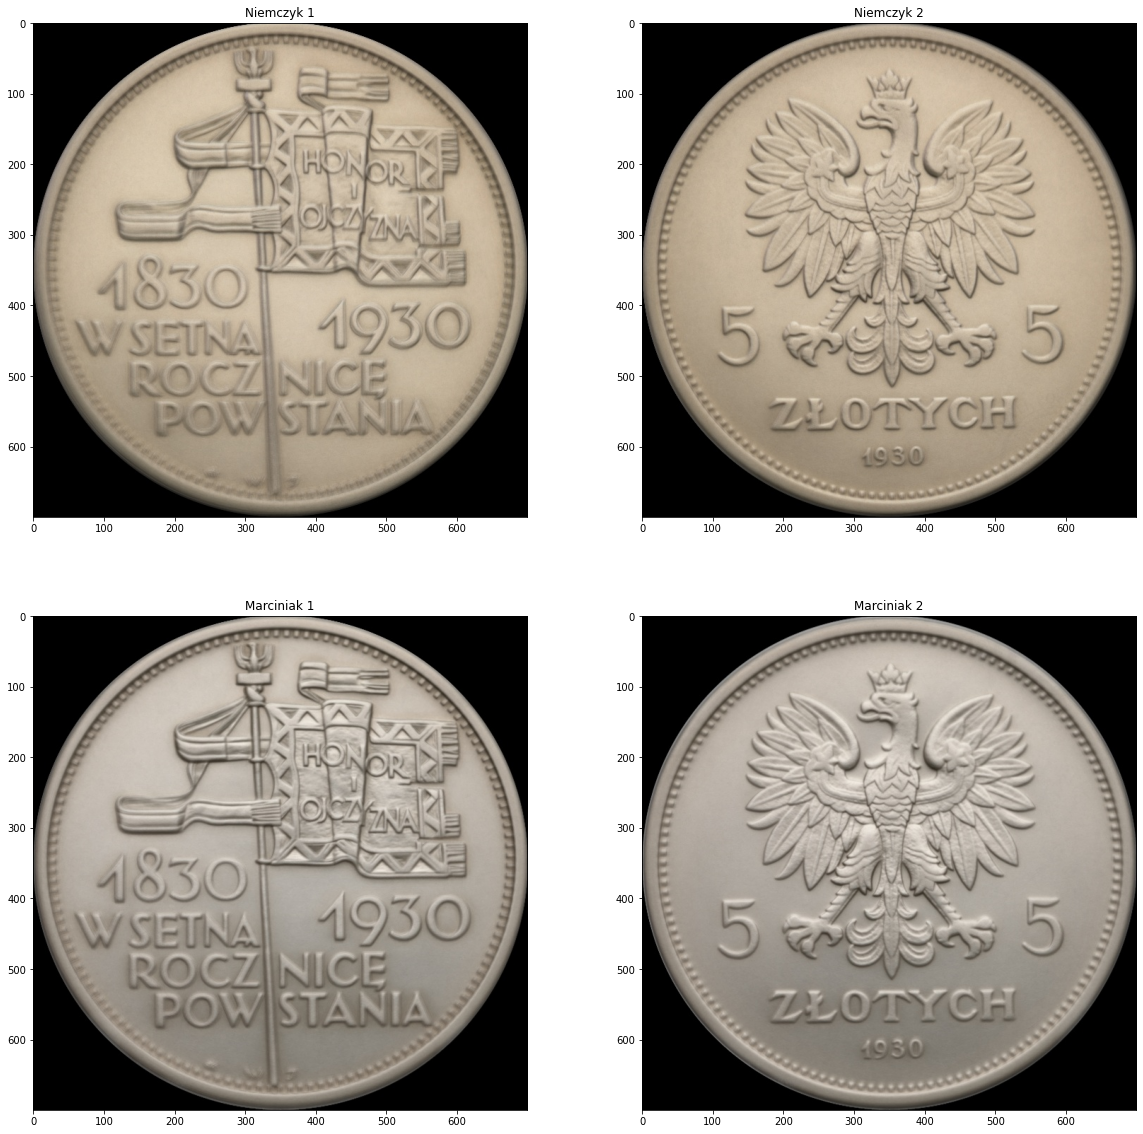

In [4]:
master_coin_1_n = cv2.imread(master_coins_path(NIEMCZYK_DATASET_PATH) + "/1.jpg")
master_coin_2_n = cv2.imread(master_coins_path(NIEMCZYK_DATASET_PATH) + "/2.jpg")
master_coin_1_m = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg")
master_coin_2_m = cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg")

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
ax1.imshow(cv2.cvtColor(master_coin_1_n, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(master_coin_2_n, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(master_coin_1_m, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(master_coin_2_m, cv2.COLOR_BGR2RGB))

ax1.set_title("Niemczyk 1")
ax2.set_title("Niemczyk 2")
ax3.set_title("Marciniak 1")
ax4.set_title("Marciniak 2")

plt.show()

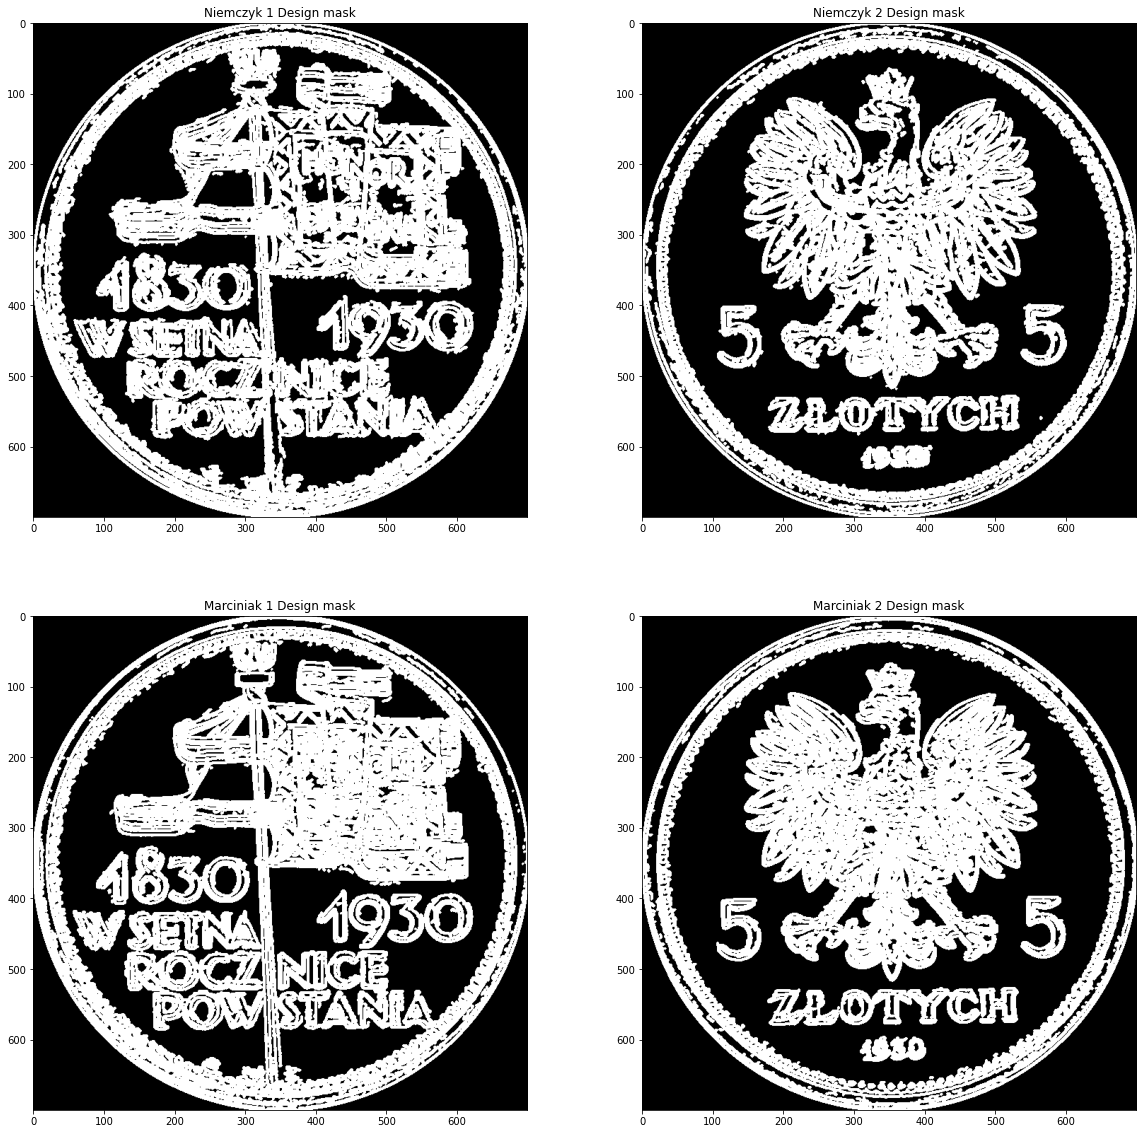

In [17]:
def get_design_mask(master_coin):
    mask = master_coin.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.Canny(mask, 0.1*255, 0.2*255)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    mask = cv2.dilate(mask, kernel ,iterations = 1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

design_mask_1_n = get_design_mask(master_coin_1_n)
design_mask_2_n = get_design_mask(master_coin_2_n)
design_mask_1_m = get_design_mask(master_coin_1_m)
design_mask_2_m = get_design_mask(master_coin_2_m)

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
ax1.imshow(cv2.cvtColor(design_mask_1_n, cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(design_mask_2_n, cv2.COLOR_BGR2RGB))
ax3.imshow(cv2.cvtColor(design_mask_1_m, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(design_mask_2_m, cv2.COLOR_BGR2RGB))

ax1.set_title("Niemczyk 1 Design mask")
ax2.set_title("Niemczyk 2 Design mask")
ax3.set_title("Marciniak 1 Design mask")
ax4.set_title("Marciniak 2 Design mask")

plt.show()

In [32]:
def get_wear_marks(coin, design_mask):
    coin = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    coin = cv2.resize(coin, (700,700))
    coin = cv2.GaussianBlur(coin, (3,3), 0.5)
    coin = cv2.Canny(coin, 0.6*255, 0.8*255)
    coin = np.multiply(~design_mask.astype(bool), coin)
    return coin

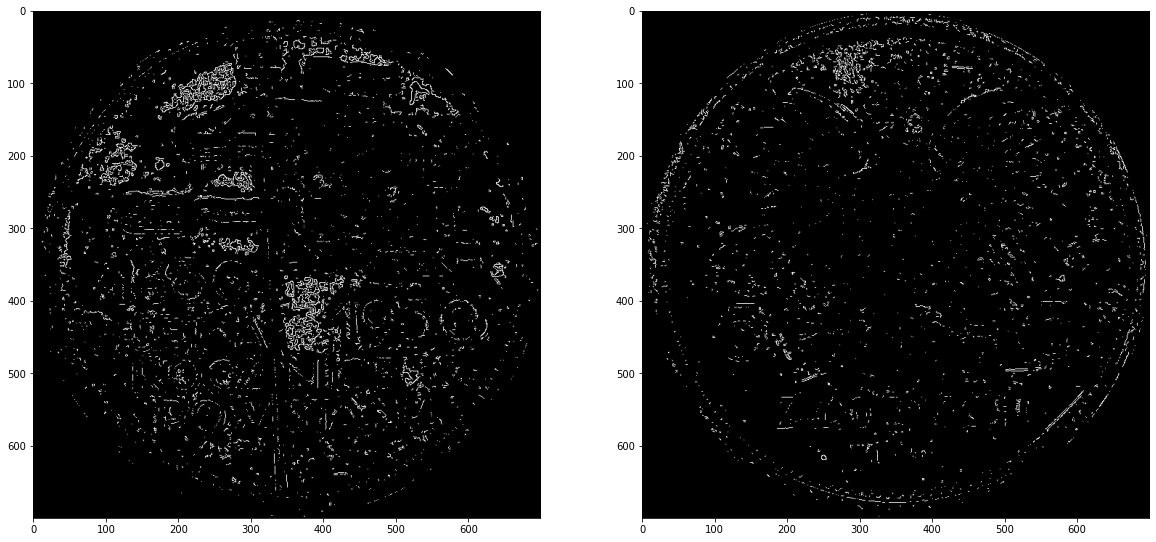

In [33]:
test_coin = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_1.jpg')
wear_marks_1 = get_wear_marks(test_coin, design_mask_1_m)

test_coin = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_2.jpg')
wear_marks_2 = get_wear_marks(test_coin, design_mask_2_m)

# sift = cv2.SIFT_create()
# kp = sift.detect(wear_marks, None)
# wear_marks = cv2.drawKeypoints(wear_marks, kp, None)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(wear_marks_1, cmap='gray')
ax[1].imshow(wear_marks_2, cmap='gray')
plt.show()

# Illumination removing

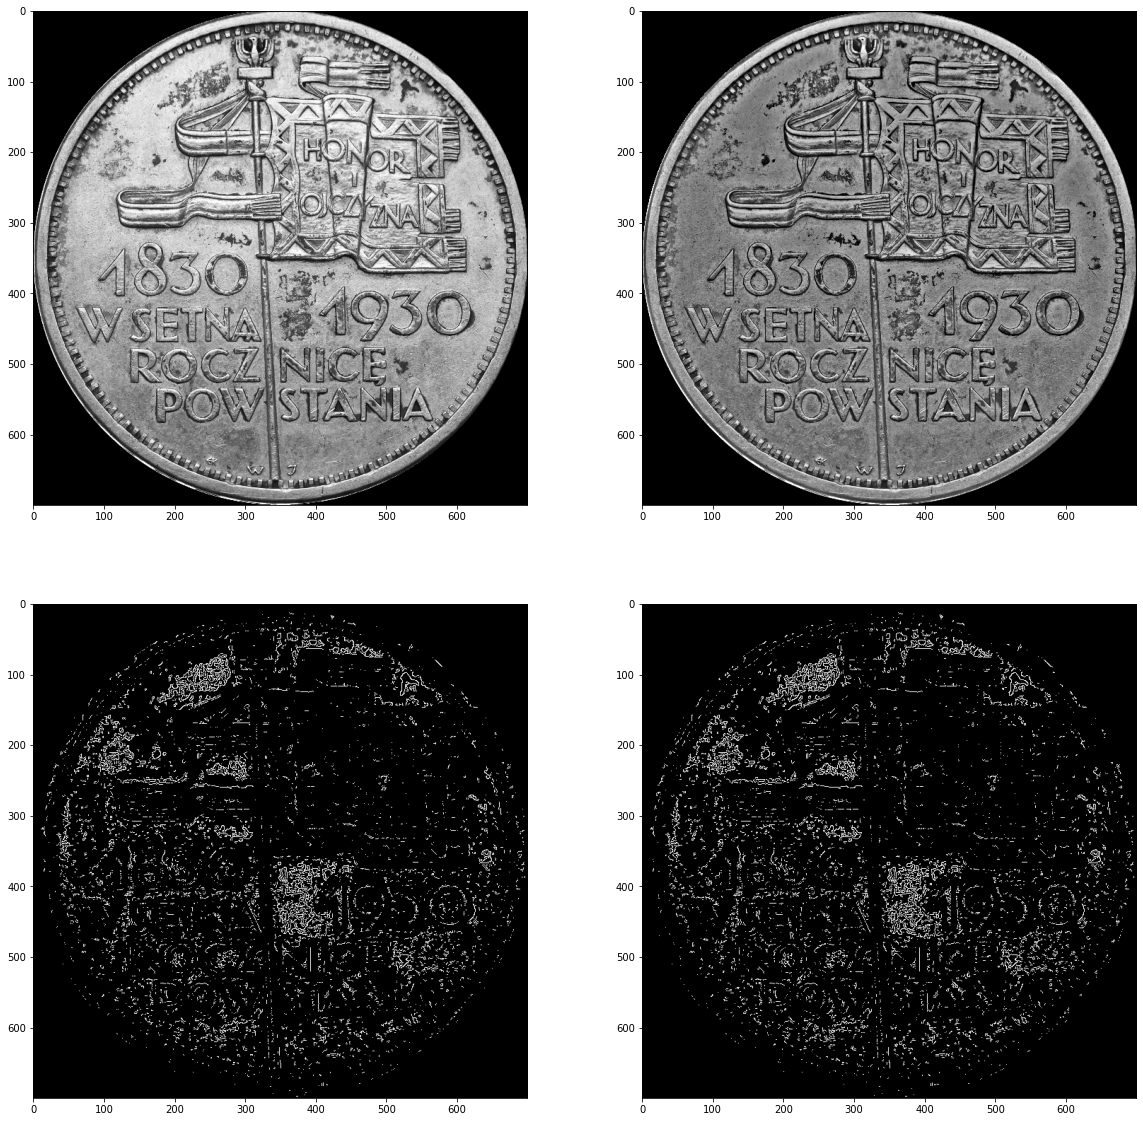

In [123]:
test_im = cv2.imread(aligned_coins_path(MARCINIAK_DATASET_PATH)+ '/1_1.jpg')
test_im = cv2.resize(test_im, (700,700))
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2GRAY)
test_im_orig = test_im.copy()
back = cv2.GaussianBlur(test_im, (61,61), 0)
test_im = test_im.astype("float")
test_im = np.subtract(test_im, back)
test_im = test_im + np.mean(back) 

mask = create_circular_mask(test_im.shape[0], test_im.shape[1])
test_im[~mask] = 0

test_im[test_im < 0] = 0
test_im[test_im > 255] = 255
test_im = np.uint8(test_im)
  
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0][0].imshow(test_im_orig, cmap='gray')
ax[0][1].imshow(test_im, cmap='gray')


test_im_orig = cv2.Canny(test_im_orig, 0.6*255, 0.8*255)
test_im_orig = np.multiply(im.astype(bool), test_im_orig)

test_im = cv2.Canny(test_im, 0.6*255, 0.8*255)
test_im = np.multiply(im.astype(bool), test_im)

ax[1][0].imshow(test_im_orig, cmap='gray')
ax[1][1].imshow(test_im, cmap='gray')

plt.show()
# sns.histplot(test_im_orig.flatten())

SVD
PCA